In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
import csv
from spec_utilities import *
# imports all from tkinter for gui
from tkinter import *

# import pandas as pd
# from mpl_interactions import ioff, panhandler, zoom_factory
# from matplotlib.animation import PillowWriter


0 -- File name:
1 -- 23cm_133Ba.Spe
2 -- 23cm_152Eu(7Nov).Spe
3 -- 23cm_152Eu.Spe
4 -- 23cm_241Am.Spe
5 -- 23cm_60Co.Spe
6 -- 82mm_133Ba.Spe
7 -- 82mm_152Eu.Spe
8 -- 82mm_241Am.Spe
9 -- 82mm_60Co.Spe
10 -- 82mm_Al.Spe
11 -- 82mm_New_152Eu.Spe
12 -- 82mm_New_60Co.Spe
13 -- Background_3-6Nov.Spe


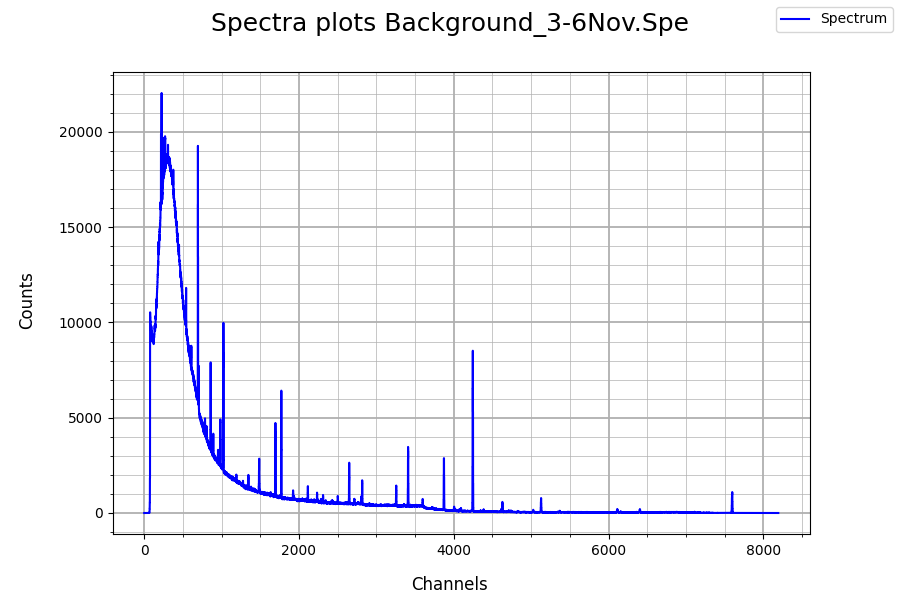

In [24]:
# importing the data in csv form provided by Cambio
filename = 'Spectra.csv'
file = get_data(filename)

# print a list of the .spe files to choose from (element is the important bit)
for i, char in enumerate(file.spectras):
    print(f'{i} -- {char}', flush=True)

index = int(input('Input integer of row of chosen file: '))

specname = file.spectras[index]
# appends data from the channel columns to form an x-axis
# appends detector data from relevant column to counts
for i, line in enumerate(file.fdata):
    if i >= 13:
        file.channels.append(float(line[0]))
        file.counts.append(float(line[index]))

# basic plot to locate the channel number of the relevant peak
fig, ax = plt.subplots(figsize=(9,6))
ax.step(file.channels, file.counts, color='blue', label='Spectrum')
fig.legend()
fig.suptitle(f"Spectra plots {specname}", size=18)
fig.supxlabel("Channels"); fig.supylabel("Counts")
ax.grid(which='major', lw=1.3); ax.grid(which='minor', lw=0.5); ax.minorticks_on()
plt.show()


In [25]:

def guess_fit(x, y, guess_0=None):
    '''guesses to minimise curve_fit run time, and point to relevant peak.'''
    if guess_0 is None:
        guess_0 = float(input('Input guess for channel peak: '))
        guess_index = x.index(guess_0)
    else:
        guess_array = np.empty_like(x)
        for i, ele in enumerate(x):
            guess_array[i] = np.abs(ele - guess_0)
            guess_index = guess_array.argmin()

    guess_1 = y[guess_index]
    guess_2 = 10
    guess = [guess_0, guess_1, guess_2]
    return guess


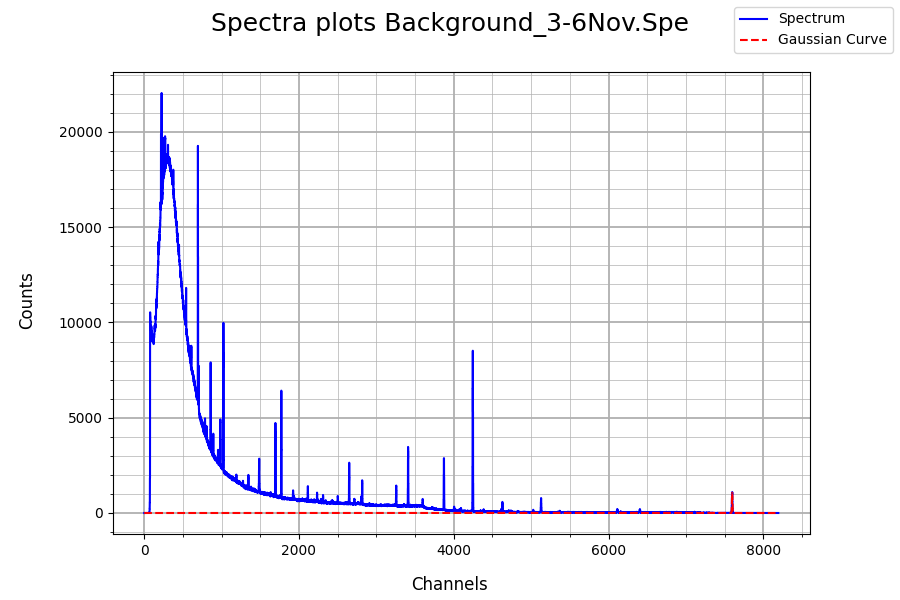

In [26]:

# using scipy curve_fit and spec_utilities file, fits a gaussian
guess = guess_fit(file.channels, file.counts)
fit, popt = gauss_fit(file.channels, file.counts, guess)

fig, ax = plt.subplots(figsize=(9,6))
ax.step(file.channels, file.counts, color='blue', label='Spectrum')
ax.plot(file.channels, fit, 'r', ls='--', label='Gaussian Curve')
fig.legend()
fig.suptitle(f"Spectra plots {specname}", size=18)
fig.supxlabel("Channels"); fig.supylabel("Counts")
ax.grid(which='major', lw=1.3); ax.grid(which='minor', lw=0.5); ax.minorticks_on()
plt.show()



In [28]:
# identifying the energy peaks associated with the file isotope
gammas = g_dict()
for ele in gammas.keys():
    if ele in specname:
        peaks = gammas[ele]
        element = ele
        print(f'List of gamma peaks for {ele} isotope:')
for i, ele in enumerate(peaks):
    print(f'{i} -- {ele}', flush=True) 

# initial calibration
peak_index = int(input('Select index of peak fitted above:'))
cal_init = peaks[peak_index]/popt[0]
energy = [i*cal_init for i in file.channels]
areas = {}

# setting up plot
fig, axs = plt.subplots(figsize=(10,6))
plt.title('Spectrum. ' + specname + '. Count rate - Energy.') 
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
axs.grid(which='major', lw=1.3); axs.grid(which='minor', linewidth=0.5); axs.minorticks_on()
plt.plot(energy, file.counts, color='blue', label='Spectrum')

for k in peaks:
    # the energy of the peak to calibrate to
    cal_erg = k

    guess = guess_fit(energy, file.counts, guess_0=k)
    print(guess)
    fits, popts = gauss_fit(energy, file.counts, guess)

    # numerical integration to calculate area under peak
    area_value = simpson(fits, energy)
    area_peak = {f'{k} keV': area_value}
    areas.update(area_peak)

    if np.abs(k - popts[0]) >= 25:
        # slicing subroutine
        print(f'{k} peak is not fitted')
        pass

    # plot individual peaks
    plt.plot(energy, fits, 'r', ls='--', label=f'Gaussian Curve {k} keV')
    axs.annotate(f'{k} keV', (popts[0], popts[1]))
    print(f'{k} keV peak, {popts[0]} keV : {popts[1]} counts')



ltime = float(file.ltimes[index])
rtime = float(file.rtimes[index])
lrtime = ltime/rtime

output = [specname, areas, len(peaks), lrtime, rtime]

save = input('Do you want to write to file? y/n: ')
if save == 'y':
    with open('efficiency.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(output)
else:
    pass

# displaying plot
plt.legend()
plt.show()


List of gamma peaks for Background isotope:
0 -- 511
1 -- 583
2 -- 2611
3 -- 609
4 -- 1120
5 -- 1764
6 -- 911
7 -- 969
8 -- 239


AttributeError: '_io.TextIOWrapper' object has no attribute 'channels'

In [22]:
total = 4537 + 3843
actv = 367961

eff = (area_peak * surface_area(filename, index)) / (actv)
peaks = [0, 1, 2, 3]



TypeError: unsupported operand type(s) for *: 'dict' and 'int'

241Am (ID 1Q532) = (367961 +/- 18398) Bq

60Co (ID Co60.283.17) = (39058 +/- 1733) Bq

133Ba (ID AO445) = (12981 +/- 618) Bq

152Eu (ID 1D152) = (49095 +/- 2455) Bq
